# Мультиклассовый Softmax классификатор
**Мовенко Константин**

Выполните задания блокнота и защитите результаты. Полностью заполненный блокнот необходимо сохранить и подгрузить в ЭОС. 

Это задание аналогично заданию исследования SVM классификатора.
В этом упражнении вы должны будете:

- реализовать полностью векторизованную **функцию потерь** для Sоftmax классификатора
- реализовать полностью векторизованное выражение для её **аналитического градиента**
- **проверить свою реализацию** с помощью численного градиента
- использовать валидационное множество для подбора **скорости обучения и коэффициента регуляризации**
- **оптимизировать** функцию потерь с помощью алгоритма **SGD**
- **визуализировать** окончательные обученные веса классификатора

In [1]:
# Выполните начальные установки блокнота.
# Внимание! Блокнот работает в версии Python 3.6!

from __future__ import print_function
import random
import numpy as np
from dlcv.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# Команды для того, чтобы изображения matplotlib отображались в блокноте,
# а не в новом окне.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # установка размеров графиков по умолчанию
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Для перезагрузки внешних модулей python;
# см. http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Загружает набор данных CIFAR-10 с диска и выполняет его предварительную обработку для 
    линейной классификации. Функция выполняет те же действия, которые выполнялись при
    подготовке данных для  SVM классификатора. Но все действия собраны в одной функции.
       
    """
    # Загрузка базы CIFAR-10.
    cifar10_dir = 'dlcv/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # выборка данных
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Предобработка: реформатирование изображений в векторы
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Нормализация данных: вычитание среднего изображения
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # добавляем в матрицы данных справа вектор из единиц для учета смещения b в составе матрицы W при вычислении 
    # s=Wx+b=w'x (трюк со смещением), в этом случае при оптимизации наm не нужно будет оптимизацировать отдельно смешения
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Очистка переменных для предотвращения повторной загрузки данных (что может вызвать проблемы с памятью)
try:
    del X_train, y_train
    del X_test, y_test
    print('Очистка ранее загруженных данных')
except:
    pass


# Вызов функции, определенной выше, создание массивов данных
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Форма массива обучающих данных:: ', X_train.shape)
print('Форма массива обучающих меток:', y_train.shape)
print('Форма валидационного массива  данных:', X_val.shape)
print('Форма валидационного массива меток:', y_val.shape)
print('Форма массива тестовых данных:', X_test.shape)
print('Форма массива тестовых меток:', y_test.shape)
print('Форма массива данных для разработки:', X_dev.shape)
print('Форма массива меток для разработки:', y_dev.shape)

Форма массива обучающих данных::  (49000, 3073)
Форма массива обучающих меток: (49000,)
Форма валидационного массива  данных: (1000, 3073)
Форма валидационного массива меток: (1000,)
Форма массива тестовых данных: (1000, 3073)
Форма массива тестовых меток: (1000,)
Форма массива данных для разработки: (500, 3073)
Форма массива меток для разработки: (500,)


## Softmax классификатор

Ваш код для этого раздела необходимо помещать в файл **dlcv/classifiers/softmax.py**. 


In [5]:
# Сначала реализуем наивную функцию потерь softmax с вложенными циклами.
# Откройте файл dlcv/classifiers/softmax.py и ознакомьтесь с функцией 
# softmax_loss_naive.

from dlcv.classifiers.softmax import softmax_loss_naive
import time

# Создание случайной весовой матрицы и использование её для вычисления потерь (loss).
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Проверка здравого смысла -  потери должны быть близкими к -log (0.1).
print('Потери: %f' % loss)
print('Потери должны быть близки к: %f' % (-np.log(0.1)))

Потери: 2.329399
Потери должны быть близки к: 2.302585


## Вопрос 1:

Почему мы ожидаем, что потери будут близки к -log (0.1)? Объясните кратко. 

**Ваш ответ:** мы имеем 10 классов изображений. Вероятность случайно угадать класс равна 1/10 (0.1). Значение -log(1/C), где C - число классов, показвает потери для случая, когда модель предсказывает все классы равновероятно. Поскольку в примере весовая матрица заполнена случайными значениями, вероятность модели отнести изображению к каждому из классов должна быть равной или близкой к равной.

In [6]:
# Просмотрите реализацию softmax_loss_naive и ознакомьтесь
# с версией вычисления градиента, которая использует вложенные циклы.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Как и для SVM, сравните результат с численным градиентом
# Численный градиент должен быть близок к аналитическому градиенту.
print('1. Без регуляризации')
from dlcv.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Аналогично случаю SVM, выполните проверку градиента с учетом регуляризации
print('2. С регуляризацией')
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

1. Без регуляризации
численный: 0.460805 аналитический: 0.460805, относительная ошибка: 1.965073e-07
численный: 0.125124 аналитический: 0.125124, относительная ошибка: 2.004916e-07
численный: 2.852618 аналитический: 2.852618, относительная ошибка: 2.094998e-08
численный: 0.496086 аналитический: 0.496086, относительная ошибка: 3.393760e-08
численный: -0.358456 аналитический: -0.358456, относительная ошибка: 1.343895e-07
численный: 0.045472 аналитический: 0.045471, относительная ошибка: 1.785441e-06
численный: -3.903093 аналитический: -3.903093, относительная ошибка: 9.660101e-09
численный: 1.868248 аналитический: 1.868248, относительная ошибка: 5.954136e-09
численный: 0.127669 аналитический: 0.127669, относительная ошибка: 3.319243e-07
численный: -1.271503 аналитический: -1.271503, относительная ошибка: 7.400119e-08
2. С регуляризацией
численный: 0.539924 аналитический: 0.539924, относительная ошибка: 3.937178e-09
численный: 0.131130 аналитический: 0.131130, относительная ошибка: 1.7557

In [7]:
# Теперь, когда у нас есть наивная реализация функции потери softmax и ее градиента,
# реализуйте векторную версию функции softmax_loss_vectorized.
# Две версии должны вычислять одни и те же результаты, но векторизованная версия должна быть
# намного быстрее.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Наивная функция потерь: %e вычислено за %fs' % (loss_naive, toc - tic))

from dlcv.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Векторизованная функция потерь: %e вычислено за %fs' % (loss_vectorized, toc - tic))

# Как и для SVM, мы используем норму Фробениуса для сравнения двух версий
# вычисления градиента.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Отличие потерь: %f' % np.abs(loss_naive - loss_vectorized))
print('Отличие градиентов: %f' % grad_difference)

Наивная функция потерь: 2.329399e+00 вычислено за 0.060579s
Векторизованная функция потерь: 2.329399e+00 вычислено за 0.008064s
Отличие потерь: 0.000000
Отличие градиентов: 0.000000


In [8]:
# Используйте валидационное множество для выбора гиперпараметров (коэффициента регуляризации и
# скорости обучения). Вы должны экспериментировать с различными значениями скорости обучения
# и коэффициента регуляризации; если вы будете аккуратны, то должны 
# получить точность классификации более 0,35 на валидационном множестве.
from dlcv.classifiers import Softmax

# results - словарь, отображающий кортежи вида (learning_rate, regularization_strength)
# в кортежи вида (training_accuracy, validation_accuracy). 
results = {}
best_val = -1                              # начальное значение наивысшей валидационной точности
best_softmax = None                        # Объект Softmax, для которого будет получена наивысшая валидац. точность.

learning_rates = [4e-7, 5e-7, 6e-7, 7e-7]              # задайте различные значения скорости обучения (4 варианта!)
regularization_strengths = [2e4, 2.5e4, 3e4, 3.5e4]    # задайте различные значения коэффициента регуляризации (4 варианта!)


################################################################################
# ЗАДАНИЕ:                                                                     #
# Используйте валидационное множество, чтобы выбрать скорость обучения         #
# и коэффициент регуляризации. Это аналогично процессу валидации, который был   #
# реализован для SVM; сохраните лучший обученный softmax классификатор в      #
# best_softmax.                                                                #
################################################################################

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, 
                                  reg=reg, num_iters=800, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        print('lr=%e reg=%e' % (lr, reg))
        print('Точность обучения: %f' % (np.mean(y_train == y_train_pred), ))
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax
        print('Валидационная точность: %f' % (np.mean(y_val == y_val_pred), ))
        results[(lr, reg)] = (train_accuracy, val_accuracy)

################################################################################
#                              КОНЕЦ ВАШЕГО КОДА                               #
################################################################################
    
# Вывод результатов
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e точность обучения: %f валидационная точность: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('Наилучшая валидационная точность полученная в ходе кросс-валидации: %f' % best_val)

итерация 0 / 800: потери 312.952883
итерация 100 / 800: потери 63.563534
итерация 200 / 800: потери 14.170201
итерация 300 / 800: потери 4.483114
итерация 400 / 800: потери 2.420825
итерация 500 / 800: потери 2.176917
итерация 600 / 800: потери 2.065415
итерация 700 / 800: потери 2.036058
lr=4.000000e-07 reg=2.000000e+04
Точность обучения: 0.353245
Валидационная точность: 0.373000
итерация 0 / 800: потери 393.727875
итерация 100 / 800: потери 53.793115
итерация 200 / 800: потери 8.882689
итерация 300 / 800: потери 2.910820
итерация 400 / 800: потери 2.175862
итерация 500 / 800: потери 2.067742
итерация 600 / 800: потери 1.984415
итерация 700 / 800: потери 2.002909
lr=4.000000e-07 reg=2.500000e+04
Точность обучения: 0.354082
Валидационная точность: 0.358000
итерация 0 / 800: потери 462.281501
итерация 100 / 800: потери 42.758946
итерация 200 / 800: потери 5.642506
итерация 300 / 800: потери 2.363556
итерация 400 / 800: потери 2.069242
итерация 500 / 800: потери 2.027689
итерация 600 / 8

In [9]:
# Оценка лучшего классификатора на тестовом множестве
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax классификатор на сырых данных, финальная точность на тестовом наборе данных: %f' % (test_accuracy, ))

Softmax классификатор на сырых данных, финальная точность на тестовом наборе данных: 0.364000


**Вопрос** - *Да или нет*

Можно ли добавить новую точку данных в обучающее множество и это оставит SVM потери без изменений, но это не верно применительно к потерям, вычисляемым Softmax классификатором.

*Ваш ответ*: да, можно

*Ваши объяснения*: при использовании классификатора SVM если добавленная точка лежит чётко в определённых классификатором границах истинного класса потери не изменятся. В то же время значение функции потерь классификатора Softmax зависит от всего множества точек данных, независимо от их вида. 

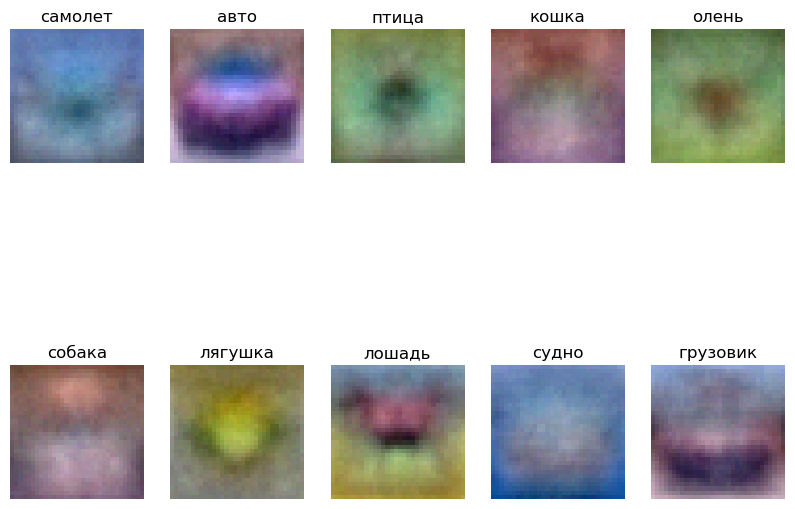

In [10]:
# Визуализация обученных весов для каждого класса.
w = best_softmax.W[:-1,:] # исключаем смещение
w = w.reshape(32, 32, 3, 10)  # приводим к размерам исходных изображений

w_min, w_max = np.min(w), np.max(w)

classes = ['самолет', 'авто', 'птица', 'кошка', 'олень', 'собака', 'лягушка', 'лошадь', 'судно', 'грузовик']
for i in range(10):
    plt.subplot(2, 5, i + 1)
     
    # Масштабирование весов, чтобы они были в диапазоне от 0 до 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])